In [1]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

class Model:
    def __init__(self):
        self.weight = np.zeros(100)
        
    def __call__(self, x: np.ndarray):
        x = (self.weight * x).sum(axis=1, keepdims=True)
        x = 1 / (1 + np.exp(-x)) 
        return x
    
    def __str__(self):
        return f'{self.weight}'

def BCELoss(pred: np.ndarray, label: np.ndarray):
    return -(label * np.log(pred) + (1 - label) * np.log(1 - pred)).mean(dtype=np.float64)

In [2]:
def preprocess_data(data):
    r'''
    compute input data of model base on g(x, y; \theta)
    '''
    transformed_data = data
    for i in range(10):
        for j in range(10):
            transformed_data = np.concatenate((transformed_data, data[:, 0:1] ** i * data[:, 1:2] ** j), axis=1)
    return transformed_data[:, 2:]


data = np.genfromtxt("data-nonlinear.txt", delimiter=',')
y_train = data[:, 2:3]
transformed_data = preprocess_data(data[:, 0:2])
transformed_data.shape

(118, 100)

In [3]:
from tqdm import tqdm

epoch = 40000
max_acc = 0

losses = []
accuracys = []
weights = []

losse = []
accuracy = []

learning_rate = 1
weight_decay = [1e-7, 1e-3, 1e-0]
model = Model()

for i in range(3):
    loss = []
    accuracy = []
    for step in tqdm(range(epoch)):
        # BCELoss
        criterion: np.ndarray = BCELoss(model(transformed_data), y_train) + weight_decay[i] * (model.weight ** 2).mean() / 2
        preds = model(transformed_data) > 0.5
        acc = (preds == y_train).sum() / y_train.shape[0]
        max_acc = max(acc.item(), max_acc)

        # Save losses and parameters
        loss += [criterion.tolist()]
        accuracy += [acc.item()]

        # Compute Error
        error = model(transformed_data) - y_train

        # Gradient Descent Algorithm
        temp_weight = (1 - learning_rate * weight_decay[i]) * model.weight - learning_rate * (error * transformed_data).mean(axis=0)

        # Update parameter
        model.weight = temp_weight
    losses += [loss]
    accuracys += [accuracy]
    weights += [model.weight]

100%|██████████| 40000/40000 [00:06<00:00, 6240.79it/s]


In [4]:
data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')
pointX  = data[:, 0]
pointY  = data[:, 1]
label   = data[:, 2]

pointX0 = pointX[label == 0]
pointY0 = pointY[label == 0]

pointX1 = pointX[label == 1]
pointY1 = pointY[label == 1]

## 1. Training Data

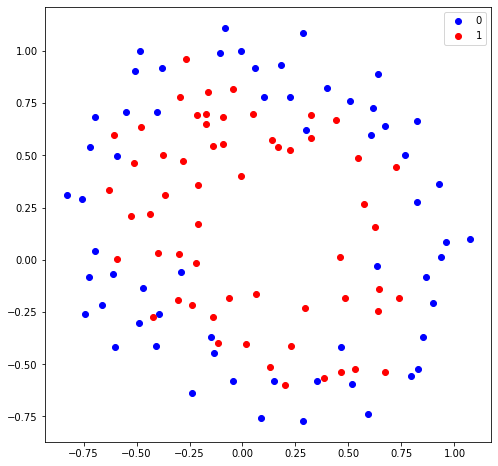

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(pointX0, pointY0, c='b', label='0')
plt.scatter(pointX1, pointY1, c='r', label='1')
plt.legend()
plt.show()

## 2. Plot the training error with varying regularization parameters

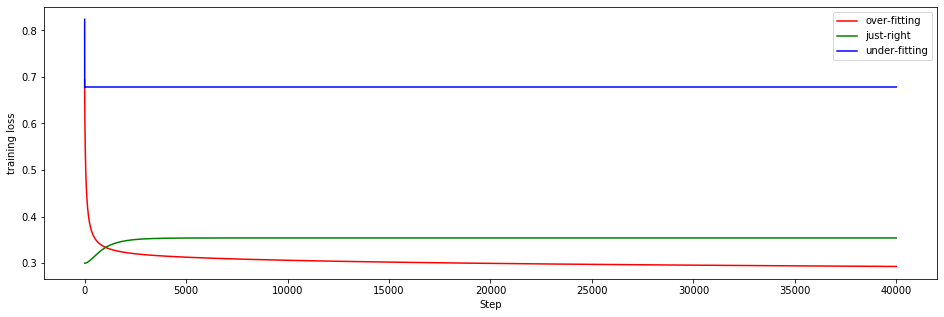

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(losses[0], c='r', label='over-fitting')
plt.plot(losses[1], c='g', label='just-right')
plt.plot(losses[2], c='b', label='under-fitting')
plt.ylabel('training loss')
plt.xlabel('Step')
plt.legend(loc='upper right')
plt.show()

## 3. Display the values of the chosen regularization parameters

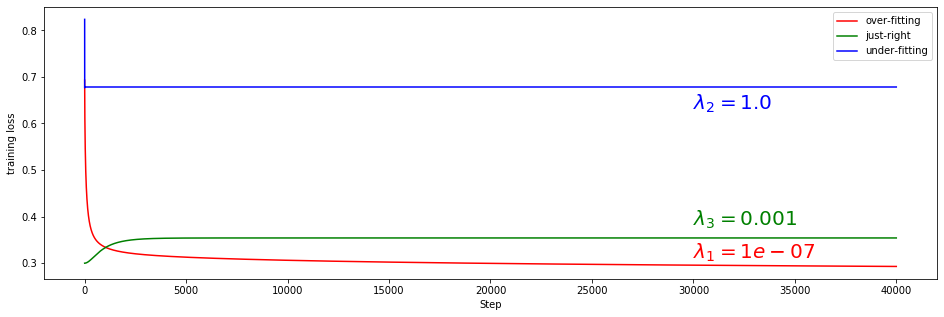

In [7]:
plt.figure(figsize=(16, 5))
plt.plot(losses[0], c='r', label='over-fitting')
plt.plot(losses[1], c='g', label='just-right')
plt.plot(losses[2], c='b', label='under-fitting')
plt.ylabel('training loss')
plt.xlabel('Step')
plt.legend(loc='upper right')

plt.text(30000, 0.31, f'$\lambda_1={weight_decay[0]}$', size=20, color='r')
plt.text(30000, 0.38, f'$\lambda_3={weight_decay[1]}$', size=20, color='g')
plt.text(30000, 0.63, f'$\lambda_2={weight_decay[2]}$', size=20, color='b')
plt.show()

## 4. Plot the training accuracy with varying regularization parameters

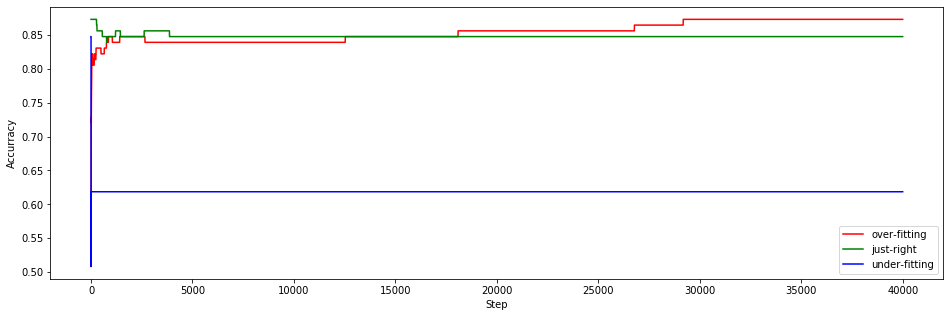

In [8]:
plt.figure(figsize=(16, 5))
plt.plot(accuracys[0], c='r', label='over-fitting')
plt.plot(accuracys[1], c='g', label='just-right')
plt.plot(accuracys[2], c='b', label='under-fitting')
plt.ylabel('Accurracy')
plt.xlabel('Step')

plt.legend(loc='lower right')
plt.show()

## 5. Display the final training accuracy with varying regularization parameters

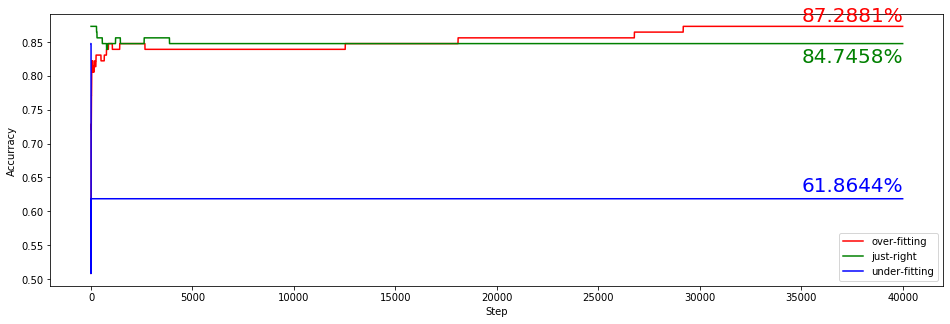

In [12]:


plt.figure(figsize=(16, 5))
plt.plot(accuracys[0], c='r', label='over-fitting')
plt.plot(accuracys[1], c='g', label='just-right')
plt.plot(accuracys[2], c='b', label='under-fitting')
plt.text(35000, 0.88, f'{accuracys[0][-1]*100:.4f}%', c='r', size=20)
plt.text(35000, 0.82, f'{accuracys[1][-1]*100:.4f}%', c='g', size=20)
plt.text(35000, 0.63, f'{accuracys[2][-1]*100:.4f}%', c='b', size=20)
plt.ylabel('Accurracy')
plt.xlabel('Step')

plt.legend(loc='lower right')
plt.show()

## 6. Plot the optimal classifier with varying regularization parameters superimposed on the training data

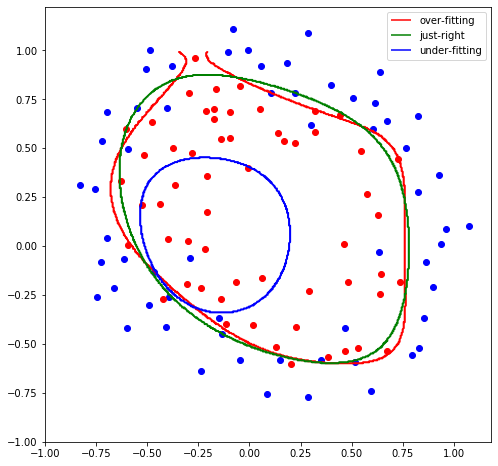

In [10]:
plt.figure(figsize=(8, 8))
plt.scatter(pointX0, pointY0, c='b', label=0)
plt.scatter(pointX1, pointY1, c='r', label=1)

x = np.arange(-1, 1, 0.005)
y = np.arange(-1, 1, 0.005)
data = np.array(np.meshgrid(x, y)).T.reshape(-1,2)

model.weight = weights[0]
over = plt.tricontour(data[:, 0:1].squeeze(), data[:, 1:2].squeeze(), (model(preprocess_data(data)) < 0.5).squeeze(), levels=1, colors='r')
model.weight = weights[1]
right = plt.tricontour(data[:, 0:1].squeeze(), data[:, 1:2].squeeze(), (model(preprocess_data(data)) < 0.5).squeeze(), levels=1, colors='g')
model.weight = weights[2]
under = plt.tricontour(data[:, 0:1].squeeze(), data[:, 1:2].squeeze(), (model(preprocess_data(data)) < 0.5).squeeze(), levels=1, colors='b')

h1,_ = over.legend_elements()
h2,_ = right.legend_elements()
h3,_ = under.legend_elements()

plt.legend([h1[0], h2[0], h3[0]], ['over-fitting', 'just-right', 'under-fitting'])
plt.show()